Hunter Bennett | Glass Lab | Kupffer Strains Project | 04 June 2021

In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib_venn as venn
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat
from homer_preprocessing import read_annotated_peaks

# Set working directory

In [2]:
dataDirectory = '/home/h1bennet/strains/data/ATAC/control_f1/'
workingDirectory = '/home/h1bennet/strains_f1/results/00_CB6F1_Control_ATAC//'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)


In [27]:
if not os.path.isdir('./figures/'):
    os.mkdir('./figures/')

### Read in annotation files

In [3]:
# import annotation file
df, mat = read_annotated_peaks('./peakQuan/allNormTags.txt')

# shorten columns to make labeling nicer
mat.columns = mat.columns.str.split('/').str[-1]

# quantile normalize data
mat_quant = quantile_normalize_df(mat)

We should filter low intensity peaks because we are not interested in them...

In [26]:
greps = [# 'tag_perfect.*mm10',
         # 'tag_perfect.*balbcj',
         'tag_only.*mm10',
         'tag_only.*balbcj']

thresh = 8
n_passing_thresh = 3
thresh_passing_peaks = []
for grep in greps:
    print(mat.loc[:, (mat.columns.str.contains(grep))].columns)
    bool_peaks = (mat.loc[:, (mat.columns.str.contains(grep))] > thresh).sum(1)>n_passing_thresh
    thresh_passing_peaks.extend(mat.index[bool_peaks])
    
mat_filt = mat.reindex(set(thresh_passing_peaks))

print("N IDR Peaks:", mat.shape[0])
print("N Peaks Passing Thresh:", len(set(thresh_passing_peaks)))
print("N Filtered Peaks:", mat_filt.shape[0])

Index(['tag_only_muts_mouse_cb6f1j_Male_Kupffer_ATAC_Chow_healthyoung_CB61A_TDT_l20210213_CTAGTACG_TCGACTAG_S7_L001_trim30.mm10.bowtie2.sam',
       'tag_only_muts_mouse_cb6f1j_Male_Kupffer_ATAC_Chow_healthyoung_CB61B_TDT_l20210213_TTCTGCCT_TTCTAGCT_S8_L001_trim30.mm10.bowtie2.sam',
       'tag_only_muts_mouse_cb6f1j_Male_Kupffer_ATAC_Chow_healthyoung_CB61C_TDT_l20210213_GCTCAGGA_CCTAGAGT_S9_L001_trim30.mm10.bowtie2.sam',
       'tag_only_muts_mouse_cb6f1j_Male_Kupffer_ATAC_Chow_healthyoung_CB61D_TDT_l20210213_AGGAGTCC_GCGTAAGA_S10_L001_trim30.mm10.bowtie2.sam'],
      dtype='object')
Index(['tag_only_muts_mouse_cb6f1j_Male_Kupffer_ATAC_Chow_healthyoung_CB61A_TDT_l20210213_CTAGTACG_TCGACTAG_S7_L001_trim30.balbcj.bowtie2_shifted_from_BALBCJ.sam',
       'tag_only_muts_mouse_cb6f1j_Male_Kupffer_ATAC_Chow_healthyoung_CB61B_TDT_l20210213_TTCTGCCT_TTCTAGCT_S8_L001_trim30.balbcj.bowtie2_shifted_from_BALBCJ.sam',
       'tag_only_muts_mouse_cb6f1j_Male_Kupffer_ATAC_Chow_healthyoung_CB61C_TDT_

Lets start by looking at the peak intensity distribution for each sample.

In [6]:
greps = ['tag_perfect.*mm10',
         'tag_perfect.*balbcj',
         'tag_only.*mm10',
         'tag_only.*balbcj']

colnames = ['c57bl6j_tag_perfect',
          'balbcj_tag_perfect',
          'c57bl6j_only_muts',
          'balbcj_only_muts']

colors = ['#31a354',
          '#3182bd',
          '#006d2c',
          '#08519c']

Extract average tag values

In [7]:
avg_tag_dict = {}
for grep, colname in zip(greps, colnames):
    avg_tag_dict[colname] = mat_filt.loc[:, mat_filt.columns.str.contains(grep)].mean(1)
    
avg_tag_df = pd.DataFrame(avg_tag_dict)

Extract proportional tag values

In [8]:
avg_tag_df['allelic_bias_perfect'] = avg_tag_df['balbcj_tag_perfect'] / (avg_tag_df['c57bl6j_tag_perfect'] + avg_tag_df['balbcj_tag_perfect'])
avg_tag_df['allelic_bias_only_muts'] = avg_tag_df['balbcj_only_muts'] / (avg_tag_df['c57bl6j_only_muts'] + avg_tag_df['balbcj_only_muts'])

Look at distribution of allelic bias in the mutated peaks

Text(0.5, 1.0, 'Mean First ASB')

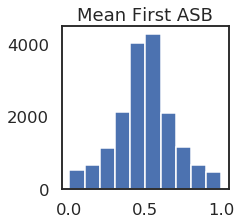

In [9]:
fig, ax = plt.subplots(figsize=(3,3))

ax.hist(avg_tag_df['allelic_bias_only_muts'].dropna());

ax.set_title('Mean First ASB')

# Check whether allelic bias computation is robust to method
Is calculating allelic bias within an individual then taking the mean equivalent?

In [12]:
mat.columns

Index(['tag_perfect_reads_mouse_cb6f1j_Male_Kupffer_ATAC_Chow_healthyoung_CB61A_TDT_l20210213_CTAGTACG_TCGACTAG_S7_L001_trim30.mm10.bowtie2.sam',
       'tag_perfect_reads_mouse_cb6f1j_Male_Kupffer_ATAC_Chow_healthyoung_CB61B_TDT_l20210213_TTCTGCCT_TTCTAGCT_S8_L001_trim30.mm10.bowtie2.sam',
       'tag_perfect_reads_mouse_cb6f1j_Male_Kupffer_ATAC_Chow_healthyoung_CB61C_TDT_l20210213_GCTCAGGA_CCTAGAGT_S9_L001_trim30.mm10.bowtie2.sam',
       'tag_perfect_reads_mouse_cb6f1j_Male_Kupffer_ATAC_Chow_healthyoung_CB61D_TDT_l20210213_AGGAGTCC_GCGTAAGA_S10_L001_trim30.mm10.bowtie2.sam',
       'tag_perfect_reads_mouse_cb6f1j_Male_Kupffer_ATAC_Chow_healthyoung_CB61A_TDT_l20210213_CTAGTACG_TCGACTAG_S7_L001_trim30.balbcj.bowtie2_shifted_from_BALBCJ.sam',
       'tag_perfect_reads_mouse_cb6f1j_Male_Kupffer_ATAC_Chow_healthyoung_CB61B_TDT_l20210213_TTCTGCCT_TTCTAGCT_S8_L001_trim30.balbcj.bowtie2_shifted_from_BALBCJ.sam',
       'tag_perfect_reads_mouse_cb6f1j_Male_Kupffer_ATAC_Chow_healthyoung_CB61C

In [13]:
samples = ['mouse_cb6f1j_Male_Kupffer_ATAC_Chow_healthyoung_CB61A_TDT_l20210213_CTAGTACG_TCGACTAG_S7_L001_trim30',
           'mouse_cb6f1j_Male_Kupffer_ATAC_Chow_healthyoung_CB61B_TDT_l20210213_TTCTGCCT_TTCTAGCT_S8_L001_trim30',
           'mouse_cb6f1j_Male_Kupffer_ATAC_Chow_healthyoung_CB61C_TDT_l20210213_GCTCAGGA_CCTAGAGT_S9_L001_trim30',
           'mouse_cb6f1j_Male_Kupffer_ATAC_Chow_healthyoung_CB61D_TDT_l20210213_AGGAGTCC_GCGTAAGA_S10_L001_trim30']

prefixes = ['tag_perfect_reads_',
            'tag_only_muts_']

In [17]:
allelic_bias_dict = {}
for samp in samples:
    samp_id = samp.split('_')[7]
    for prefix in prefixes:
        balb = mat_filt.loc[:, prefix+samp+'.balbcj.bowtie2_shifted_from_BALBCJ.sam']
        c57 = mat_filt.loc[:, prefix+samp+'.mm10.bowtie2.sam']
        
        allelic_bias_dict[prefix+samp_id] = balb / (balb+c57)
        
allelic_bias_df = pd.DataFrame(allelic_bias_dict)

only_muts_allelic_bias = allelic_bias_df.loc[:, allelic_bias_df.columns.str.contains('only_muts')]

### Mean-variance relationship for peaks

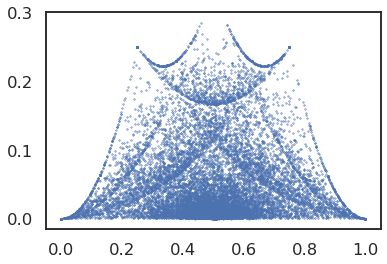

In [18]:
plt.scatter(only_muts_allelic_bias.dropna().mean(1),
            only_muts_allelic_bias.dropna().var(1),
            s=0.3)

How do mean and variance depend on sample expression

In [19]:
avg_tag_df['mean_second_asb_mean'] = only_muts_allelic_bias.dropna().mean(1)
avg_tag_df['mean_second_asb_var'] = only_muts_allelic_bias.dropna().var(1)

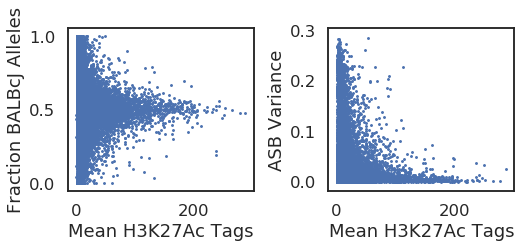

In [20]:
fig, axs = plt.subplots(1,2, figsize=(8,3))
plt.subplots_adjust(wspace=0.4)

axs[0].scatter(avg_tag_df.loc[:, ['c57bl6j_tag_perfect', 'balbcj_tag_perfect']].mean(1),
               avg_tag_df.loc[:, 'mean_second_asb_mean'],
                              s=2)

axs[0].set_ylabel('Fraction BALBcJ Alleles')
axs[0].set_xlabel('Mean H3K27Ac Tags');

axs[1].scatter(avg_tag_df.loc[:, ['c57bl6j_tag_perfect', 'balbcj_tag_perfect']].mean(1),
               avg_tag_df.loc[:, 'mean_second_asb_var'],
                              s=2)

axs[1].set_ylabel('ASB Variance')
axs[1].set_xlabel('Mean H3K27Ac Tags');

Compare distributions directly

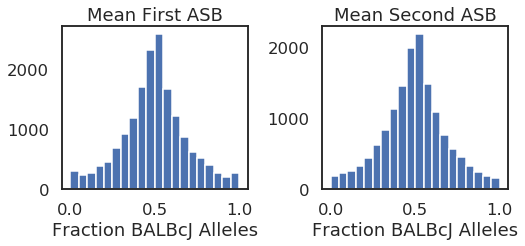

In [21]:
fig, axs = plt.subplots(1,2, figsize=(8,3))
plt.subplots_adjust(wspace=0.4)

axs[0].hist(avg_tag_df['allelic_bias_only_muts'].dropna(),
            bins=20);
axs[0].set_title('Mean First ASB')
axs[0].set_xlabel('Fraction BALBcJ Alleles');

axs[1].hist(only_muts_allelic_bias.dropna().mean(1),
            bins=20);
axs[1].set_title('Mean Second ASB');
axs[1].set_xlabel('Fraction BALBcJ Alleles');

# Directly compare estimates of allelic bias

In [22]:
avg_tag_df['allelic_bias_only_muts_mean_second'] = only_muts_allelic_bias.mean(1)

Text(0, 0.5, 'Allelic Bias Mean TPM Second')

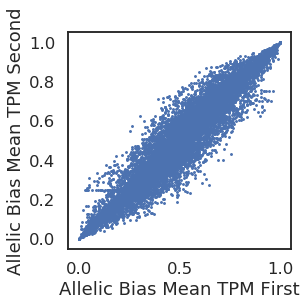

In [23]:
fig, ax = plt.subplots(figsize=(4,4))

ax.scatter(avg_tag_df['allelic_bias_only_muts'],
           avg_tag_df['allelic_bias_only_muts_mean_second'],
           s=2)

ax.set_xlabel('Allelic Bias Mean TPM First')
ax.set_ylabel('Allelic Bias Mean TPM Second')

These do generally agree but there are some big disagreements! We can take a look at them on the genome browser.

In [24]:
avg_tag_df['abs_asb_diff'] = (avg_tag_df['allelic_bias_only_muts'] - avg_tag_df['allelic_bias_only_muts_mean_second']).abs()

In [25]:
df_asb = df.iloc[:, :5].merge(
    avg_tag_df.loc[:, ['c57bl6j_tag_perfect',
                       'balbcj_tag_perfect',
                       'allelic_bias_only_muts',
                       'allelic_bias_only_muts_mean_second',
                       'abs_asb_diff',
                       'mean_second_asb_mean',
                       'mean_second_asb_var']].dropna(),
    left_index=True,
    right_index=True,
    how='right')

df_asb['location'] = df.Chr+':'+df.Start.astype(str)+'-'+df.End.astype(str)

df_asb.to_csv('./peaks_with_asb_min_tag_filter.txt',
              sep='\t')